# [Function Calling](https://openai.com/blog/function-calling-and-other-api-updates)
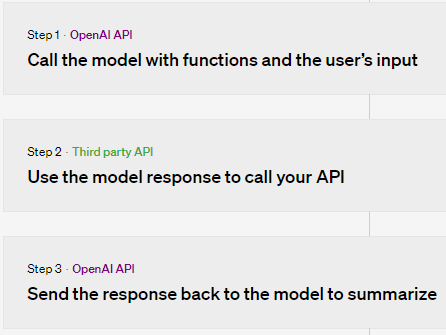

# Libraries and Constants

In [2]:
from openai import AzureOpenAI # https://github.com/openai/openai-python
from dotenv import load_dotenv
from IPython.display import Markdown, HTML, display  
import json

load_dotenv("./credentials_my.env")

MODEL = "gpt4-1106-128k"
QUESTION = "How many flights between Christmas 2020 and Easter 2021? How much is 72^0.43? When was my cat born?"

client = AzureOpenAI(
    azure_endpoint = os.environ['AZURE_OPENAI_ENDPOINT'],
    api_key        = os.environ['AZURE_OPENAI_API_KEY'],
    api_version    = os.environ['AZURE_OPENAI_API_VERSION']
)

def printmd(string):
    # string = string.replace('\n', '<br/>')
    display(Markdown(string))
      
def printmd_indented(string):
    # Split the string into lines, indent each line, and then join them back into a single string
    indented_string = '\n'.join(f"> {line}" for line in string.strip().split('\n'))
    display(Markdown(indented_string))

In [3]:
messages = [
    {
        "role": "user",
        "content": QUESTION
    }
]

response = client.chat.completions.create(
                model       = MODEL,
                messages    = messages
            )


prompt_tokens     = response.usage.prompt_tokens
completion_tokens = response.usage.completion_tokens
total_tokens      = response.usage.total_tokens

In [4]:
print(messages)

[{'role': 'user', 'content': 'How many flights between Christmas 2020 and Easter 2021? How much is 72^0.43? When was my cat born?'}]


In [5]:
print(prompt_tokens, completion_tokens, total_tokens)

37 187 224


In [6]:
print(response)

ChatCompletion(id='chatcmpl-8uO68zkz6wxjKk0IrUtmryYXHofRH', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content="1. To determine the exact number of flights between Christmas 2020 and Easter 2021, this information can't be provided without current flight data. The number of flights during this period would have been influenced by the COVID-19 pandemic, and commercial airline data would vary. You would need to consult a database that keeps historical records of flight schedules for the exact number.\n\n2. To calculate 72^0.43, we can use a calculator to find that:\n\n72^0.43 ≈ 4.19429997\n\nThus, 72 raised to the power of 0.43 is approximately 4.1943.\n\n3. Without further information about your cat such as date of birth or age, it is impossible for me to state when your cat was born. If you have more details about your cat's age or specific date-related information, you may be able to approximate your cat’s birth date.", role='assistant', function_call=

# Let's build new custom functions

## Define the functions. They will be used through the tools.

In [7]:
failure_rate = .0

def get_flights(date_1, date_2):
    """ Returns the number of flights in a date interval  """
    import json
    from dateutil.parser import parse
    flights = {
        "flights": abs((parse(date_2) - parse(date_1)).days) 
    }
    return json.dumps(flights)


def elevation_to_power(base, power):
    """ Calculates the result of <base> elevated to <power> """
    import json
    elevation_to_power_result = {
        "result": float(base) ** float(power)
    }
    return json.dumps(elevation_to_power_result)


def web_search(question):
    """ Does a WEB search and returns the content of first page found """
    from langchain.utilities import BingSearchAPIWrapper
    bing_search = BingSearchAPIWrapper()
    search_result = {
        "search_result": bing_search.run(question)
    }
    return json.dumps(search_result)


def current_year():
    """ Returns the current year """
    import datetime
    current_year = {
        "current_year": datetime.datetime.now().year
    }
    return json.dumps(current_year)


def current_date():
    """ Returns the current date """
    import datetime
    current_date = {
        "current_date": datetime.date.today().strftime("%Y-%m-%d")
    }
    return json.dumps(current_date)


def my_cat_born_date():
    """ Returns my cat's born date """
    import datetime, random
    from dateutil.relativedelta import relativedelta
    
    if (random.uniform(0, 1)<failure_rate):
        raise Exception("Simulated error in my_cat_born_date for testing purpose")
        
    # Calculate the date as ten years ago  
    ten_years_ago = datetime.date.today() - relativedelta(years=10) 
    
    cat_born_date = {
        "cat_born_date": ten_years_ago.strftime("%Y-%m-%d")
    }
    return json.dumps(cat_born_date)


def custom_calculator(mathematical_question):
    """ useful for when you need to answer questions about math """
    from langchain.chat_models import AzureChatOpenAI
    from langchain import LLMMathChain # requires 'numexpr' module
    import random
    
    if (random.uniform(0, 1)<failure_rate):
        raise Exception("Simulated error in custom_calculator for testing purpose")
        
    llm = AzureChatOpenAI(deployment_name=MODEL, temperature=0, max_tokens=1000)
    llm_math_chain = LLMMathChain.from_llm(llm, verbose=False)
    
    math_result = {
        "math_result": llm_math_chain.run(mathematical_question).split(' ')[-1]
    }
    return json.dumps(math_result)


def get_days_difference(date_1, date_2):
    """ calculate the distance (in days) between two dates """
    import json, random
    from dateutil.parser import parse
    
    if (random.uniform(0, 1)<failure_rate):
        raise Exception("Simulated error in get_days_difference for testing purpose")
    
    days = {
        "days": abs((parse(date_2) - parse(date_1)).days) 
    }
    return json.dumps(days)

# Eval
eval("get_flights")(**{"date_1": "1736-03-22", "date_2": "2175-10-17"})

In [8]:
command = "print(3*5)"
eval("get_flights")(**{"date_1": "1736-03-22", "date_2": "2175-10-17"})

'{"flights": 160550}'

## invoke the functions directly and *in*-directly

In [9]:
print("First, we call the functions directly:")
print(get_flights("2023-12-28", "31/12/2023"))
print(elevation_to_power("5", "3"))
print(web_search("Who is the wife of Joe Biden?")[:80])
print(current_year())
print(current_date())
print(my_cat_born_date())
print(custom_calculator("how much is 3*5?"))
print(get_days_difference("2023-12-28", "31/12/2023"))

print("\nThen, we pass the function NAMES to the EVAL function:")
print (eval("get_flights")(**{"date_1": "1736-03-22", "date_2": "2175-10-17"}))
print (eval("elevation_to_power")(**{"base": 5, "power": 3}))
print (eval("web_search")(**{"question": "Who is the wife of Joe Biden?"})[:80])
print (eval("current_year")())
print (eval("current_date")())
print (eval("my_cat_born_date")())
print (eval("custom_calculator")(**{"mathematical_question": "how much is 3*5?"}))
print (eval("get_days_difference")(**{"date_1": "1736-03-22", "date_2": "2175-10-17"}))

First, we call the functions directly:
{"flights": 3}
{"result": 125.0}


HTTPError: 401 Client Error: PermissionDenied for url: https://api.bing.microsoft.com/v7.0/search?q=Who+is+the+wife+of+Joe+Biden%3F&count=10&textDecorations=True&textFormat=HTML

## Describe the functions through the [tools](https://platform.openai.com/docs/api-reference/chat/create)

In [10]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_flights",            
            "description": "returns the number of flights between two dates",
            "parameters": {
                "type": "object",
                "properties": {
                    "date_1": {"type": "string", "description": "the first date"},
                    "date_2": {"type": "string", "description": "the second date"}
                }
            },
            "required": ["date_1", "date_2"]
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_days_difference",            
            "description": "useful when you need to calculate the absolute number of days between two dates",
            "parameters": {
                "type": "object",
                "properties": {
                    "date_1": {"type": "string", "description": "the first date"},
                    "date_2": {"type": "string", "description": "the second date"}
                }
            },
            "required": ["date_1", "date_2"]
        }
    },
    {
        "type": "function",
        "function": {
            "name": "elevation_to_power",
            "description": "calculate the mathematical result of a number elevated to the power of another number",
            "parameters": {
                "type": "object",
                "properties": {
                    "base": {"type": "string", "description": "the base number"},
                    "power": {"type": "string", "description": "the power to elevate the base number to"}
                }
            },
            "required": ["base", "power"]
        }
    },
    {
        "type": "function",
        "function": {
            "name": "web_search",            
            "description": "useful for when you need to answer questions about current events",
            "parameters": {
                "type": "object",
                "properties": {
                    "question": {"type": "string", "description": "the text string to search on the WEB"}
                }
            },
            "required": ["question"]
        }
    },
    {
        "type": "function",
        "function": {
            "name": "current_year",            
            "description": "returns the current year",
            "parameters": {
                "type": "object",
                "properties": {                    
                }
            },
            "required": []
        }
    },
    {
        "type": "function",
        "function": {
            "name": "current_date",            
            "description": "returns the current date",
            "parameters": {
                "type": "object",
                "properties": {
                    
                }
            },
            "required": []
        }
    },
    {
        "type": "function",
        "function": {
            "name": "my_cat_born_date",            
            "description": "returns my cat's born date",
            "parameters": {
                "type": "object",
                "properties": {
                    
                }
            },
            "required": []
        }
    },
    {
        "type": "function",
        "function": {
            "name": "custom_calculator",            
            "description": "useful for when you need to answer questions about math",
            "parameters": {
                "type": "object",
                "properties": {
                    "mathematical_question": {"type": "string", "description": "the text string to search on the WEB"}
                }
            },
            "required": ["mathematical_question"]
        }
    }
]

## LLM using tools to extract function name and parameters based on the question
Recall:
- **functions** is deprecated in favor of **tools**
- **function_call** is deprecated in favor of **tool_choice**<br/>

Reference: [how to create chat completions](https://platform.openai.com/docs/api-reference/chat/create)

In [11]:
QUESTION

'How many flights between Christmas 2020 and Easter 2021? How much is 72^0.43? When was my cat born?'

In [12]:
completion = client.chat.completions.create(
    model  = MODEL,
    messages = [
        {
            "role": "user",
            "content": QUESTION
        }
    ],
    tools = tools,
    tool_choice = "auto"
)

completion # includes the selected function(s) and corresponding arguments

ChatCompletion(id='chatcmpl-8uO7E6wBgEofg202CIWIwUBwMx8cX', choices=[Choice(finish_reason='tool_calls', index=0, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_t3qte7BPzpqGLI30uFXbIMvb', function=Function(arguments='{"date_1": "2020-12-25", "date_2": "2021-04-04"}', name='get_flights'), type='function'), ChatCompletionMessageToolCall(id='call_oipJoOvDjevPbAyULMXfXis0', function=Function(arguments='{"base": "72", "power": "0.43"}', name='elevation_to_power'), type='function'), ChatCompletionMessageToolCall(id='call_Ltx96DUXebVifdcx4lZdQ5VO', function=Function(arguments='{}', name='my_cat_born_date'), type='function')]), content_filter_results={})], created=1708449760, model='gpt-4', object='chat.completion', system_fingerprint='fp_46925cd5d1', usage=CompletionUsage(completion_tokens=132, prompt_tokens=324, total_tokens=456), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': 

In [13]:
completion.choices[0].message.model_dump()

{'content': None,
 'role': 'assistant',
 'function_call': None,
 'tool_calls': [{'id': 'call_t3qte7BPzpqGLI30uFXbIMvb',
   'function': {'arguments': '{"date_1": "2020-12-25", "date_2": "2021-04-04"}',
    'name': 'get_flights'},
   'type': 'function'},
  {'id': 'call_oipJoOvDjevPbAyULMXfXis0',
   'function': {'arguments': '{"base": "72", "power": "0.43"}',
    'name': 'elevation_to_power'},
   'type': 'function'},
  {'id': 'call_Ltx96DUXebVifdcx4lZdQ5VO',
   'function': {'arguments': '{}', 'name': 'my_cat_born_date'},
   'type': 'function'}]}

## Run the function(s)
- extract the function name from the *completion* returned in the previous cell
- extract the arguments from the *completion*, then convert it to a dictionary object
- use **eval** to run the function with its argument
- retrieve the result into a new dictionary object, and print it

### this is just for debugging purposes...

In [14]:
for tool_call in completion.choices[0].message.tool_calls:
    role = completion.choices[0].message.role
    function_name = tool_call.function.name
    function_args = json.loads(tool_call.function.arguments)
    function_answer = {
        "role": "tool",
        "name": function_name,
        "function_args": function_args, # use function_args.get("parameter_name") to get its value
        "answer": eval(function_name)(**function_args),
    }
    print(function_answer)

{'role': 'tool', 'name': 'get_flights', 'function_args': {'date_1': '2020-12-25', 'date_2': '2021-04-04'}, 'answer': '{"flights": 100}'}
{'role': 'tool', 'name': 'elevation_to_power', 'function_args': {'base': '72', 'power': '0.43'}, 'answer': '{"result": 6.290033717412419}'}
{'role': 'tool', 'name': 'my_cat_born_date', 'function_args': {}, 'answer': '{"cat_born_date": "2014-02-20"}'}


### ...while the following cell creates a "tool" message for each "tool_call" included in the assistant messages

In [ ]:
messages = []

# USER MESSAGE
message_user = {"role": "user", "content": QUESTION}
messages.append(message_user)

if (completion):
    first_response = completion
else:
    first_response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        tools=tools,
        tool_choice="auto",  # auto is default, but we'll be explicit
    )

# FIRST ASSISTANT MESSAGE
# Here we build a second message whose role is "assistant" that contains the answer from the previous call
message_assistant = first_response.choices[0].message.model_dump()
message_assistant.pop('function_call')
messages.append(message_assistant)

# TOOL MESSAGES
# We must create a "tool" message for each 'tool_call_id' included in the "tool_calls" array of the assistant message
for tc in message_assistant['tool_calls']:
    function_name = tc["function"]["name"]
    function_args = json.loads(tc["function"]["arguments"])
    
    function_resp = eval(function_name)(**function_args) # THIS IS THE CALL TO OUR LOCAL FUNCTIONS!
        
    message_tool = {   
        "role": "tool",
        "name": function_name,
        "tool_call_id": tc["id"],
        "content": function_resp
    }     
    messages.append(message_tool)
    
messages

## Now we pass the full list of messages to a second completion call
This returns a *second set* of **assistant** messages

In [ ]:
second_response = client.chat.completions.create(
    model       = MODEL,
    messages    = messages,
    tools       = tools,
    tool_choice = 'auto'
)

second_response

In [ ]:
if (second_response.choices[0].finish_reason=='stop'):
    printmd(f'**We have the final answer**<br/>{second_response.choices[0].message.model_dump()["content"]}')
else:
    print (f"We still need at least another reasoning step: {second_response}")

# All answers in a single loop until finish_reason='stop'

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [ ]:
%%time

QUESTION = """Calculate the number of flights between Christmas 2020 and Easter 2021, 
elevated to the power of 0.43 
and multiplied by the number of days since my cat was born"""

SYSTEM_MESSAGE = """You are an AI assistant that helps people find information.
Please provide two kinds of answers:

1. First, give just a concise and high level response following these rules:   
   - **JUST** detail the high level steps you would follow to achieve this result, next to the reason why you identified each one. 
   - **ALWAYS** think step by step.
   - Do **NOT** provide any details about the sub-tasks you would do to achieve each step.
   - Do **NOT** provide any examples to explain how you will implement the solution.
   - Do **NOT** do any calculations or simulations.
   - Do **NOT** use any external tools to do this, just use your internal knowledge.

2. Second, implement one by one the needed steps, harnessing the tools provided. Furthermore, for each step:   
   - Explain the reason why you chose that action and the functions.
   - **NEVER** call a function if you do not have **all** required parameters of that function.
   - **NEVER** use your internal knowledge to guess any date-related information.
   
At the end, **ALWAYS** provide a detailed description of the whole process that you followed to achieve the result, using well formatted markup language. Use wonderful formatted markdown answers."""


messages = []

# SYSTEM MESSAGE
message_system = {"role": "system", "content": SYSTEM_MESSAGE}
messages.append(message_system)

# USER MESSAGE
message_user = {"role": "user", "content": QUESTION}
messages.append(message_user)

printmd(f'<h1><span style="color:darkblue;">Given this SYSTEM_MESSAGE...</h1>')
printmd_indented(f'{message_system["content"]}')

printmd(f'<h1><span style="color:darkblue;">...and your QUESTION...</h1>')
printmd_indented(f'*<span style="font-size:larger;color:blue;">{message_user["content"]}</span>*')

printmd(f'<h1><span style="color:darkblue;">...now, the fun BEGINS!</h1>')

keep_asking_completions = True

cumulative_total_tokens = 0
completion_count        = 1
max_attempts            = 10 # we accept up to these attempts by completion
attempt_nr              = 1

while (attempt_nr <= max_attempts):
    try:        
        while keep_asking_completions: # run the below block until finish_reason='stop', or just the first time
            totaltokens_toolcalls = 0
            
            if (attempt_nr == 1): # we use green color if this is the first attempt
                printmd(f'<h2><span style="color:darkgreen;">Creating completion request #{completion_count}...</h2>')
            else: # we use purple color if this is NOT the first attempt
                printmd(f'<h2><span style="color:purple;">Creating completion request #{completion_count} *again* (attempt #{attempt_nr}) ...</h2>')
            
            response = client.chat.completions.create(
                model       = MODEL,
                messages    = messages,
                tools       = tools,
                tool_choice = 'auto'
            )
            
            prompt_tokens     = response.usage.prompt_tokens
            completion_tokens = response.usage.completion_tokens
            total_tokens      = response.usage.total_tokens
            totaltokens_toolcalls = totaltokens_toolcalls + total_tokens
            
            finish_reason = response.choices[0].finish_reason
            
            if completion_count==1: # print the steps just after the first call
                # printmd_indented(f'<span style="color:darkgreen;">{response.choices[0].message.content}</span><br/>')
                if (finish_reason == "stop"):
                    raise Exception("Error: first call to OpenAI didn't choose any tools to run")
                else:
                    printmd_indented(response.choices[0].message.content)
            

            printmd(f'<span style="font-size:larger;color:orange;">...which consumed **{prompt_tokens}** prompt + **{completion_tokens}** completion tokens (=**{total_tokens}** total tokens)<br/>and terminated with finish_reason = `{finish_reason}`')
            
            if finish_reason == "stop":
                printmd(f'<h2><span style="color:darkgreen;">Hooray! All completions were successfully executed. We have reached the end of the chain!</span></h2>')
                keep_asking_completions = False
                break # exit while: all calls terminated well and we have our final solution
            
            message_assistant = response.choices[0].message.model_dump()
            message_assistant.pop('function_call') # <<<--- ASSISTANT MESSAGE IS READY, WE ADD IT IF ALL FUNCTIONS WORK WELL
            
            messages_toolcalls = [] # we need to create a "tool" message for each function in message_assistant.tool_calls
            
            printmd(f'<span style="font-size:larger;color:darkgreen;">As a result, the assistant indentified `{len(message_assistant["tool_calls"])} function(s)`, that I\'m now going to run:</span>')
            # printmd(f'<h2><span style="color:darkgreen;">The assistant indentified **{len(message_assistant['tool_calls'])}** function(s), that I\'m now going to run:</h2>')
            function_nr = 1
            for tc in message_assistant['tool_calls']:
                    function_name = tc["function"]["name"]
                    function_args = json.loads(tc["function"]["arguments"])
                    
                    printmd_indented (f'<span style="color:darkgreen;">{function_nr}) Running function `{function_name}({function_args})` in completion `#{completion_count}`, that returns...</span>')
                    function_resp = eval(function_name)(**function_args) # THIS IS THE CALL TO OUR LOCAL FUNCTIONS!
                    printmd_indented (f'>...<span style="color:darkblue;">{function_resp}</span><br/>')

                    message_tool = {   
                        "role": "tool",
                        "name": function_name,
                        "tool_call_id": tc["id"],
                        "content": function_resp
                    }     
                    messages_toolcalls.append(message_tool)
                    function_nr = function_nr + 1
                    
            messages.append(message_assistant)
            for mt in messages_toolcalls:
                messages.append(mt)
                
            
            # We are at the end of the completion, which executed all its functions without any errors    
            cumulative_total_tokens = cumulative_total_tokens + totaltokens_toolcalls
            completion_count = completion_count + 1
            attempt_nr = 1 # here we reset the attempt number to allow max_attempts for each completion
        
        break # exit the attempts loop
        
    except Exception as e:
        cumulative_total_tokens = cumulative_total_tokens + totaltokens_toolcalls
        printmd_indented(f'><span style="color:red;">The following error occurred in completion #{completion_count} during the execution of `{function_name}{function_args}`: `{e}`. I will now try the attempt #{attempt_nr+1}...</span>')
        attempt_nr = attempt_nr + 1
        keep_asking_completions = True

if (attempt_nr<=max_attempts):    
    printmd(f'<h1><span style="color:blue;">Now I have the final answer, which used {cumulative_total_tokens} cumulative tokens</span></h1></span>')
    printmd(response.choices[0].message.content)
else:
    printmd(f'<h1><span style="color:red;">Unfortunately, we exeeded the amount of allowed errors ({max_attempts}) in completion {completion_count}, so we couldn\'t get to the final solution. Please analyze the erros, fix your tools and retry.</span></h1></span>')

In [ ]:
messages

In [ ]:
response

# Documentation
- Microsoft Docs: [How to use function calling with Azure OpenAI Service (Preview)](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/function-calling?tabs=python)
- Open AI Documentation: [OpenAI Reference Guid: how to create chat completions](https://platform.openai.com/docs/api-reference/chat/create)
- YouTube Video: [OpenAI Function Calling - FULL Beginner Tutorial (video tutorial)](https://youtu.be/aqdWSYWC_LI)
- Medium Article: [LangChain Agents With OpenAI Function Calling](https://cobusgreyling.medium.com/langchain-agents-with-openai-function-calling-54a6e5573ec9)
- Article [What's the difference between Langchain Agents and OpenAI Functions?](https://mikulskibartosz.name/difference-between-langchain-agents-and-openai-functions)